# Context
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

# Attribute Information
1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

### Acknowledgements
(Confidential Source) - Use only for educational purposes
If you use this dataset in your research, please credit the author.

Other Datasets
Hepatitis C Dataset: LINK

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data getting, cleaning, and exploring
import wrangle as w
import explore as ex

# Python without these is hard
import pandas as pd
import numpy as np
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.impute import SimpleImputer, KNNImputer
# Regression Modeling
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Hypotheses:

- Heart disease will be a driver of stroke
- Decision tree will be my best model due to the large amount of binary features
- Age will be a significant factor of my model


In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [4]:
w.missing_zero_values_table(df)

Your selected dataframe has 12 columns and 5110 Rows.
There are 1 columns that have NULL values.


,Zero Values,NULL Values,% of Total NULL Values,Total Zero's plus NULL Values,% Total Zero's plus NULL Values,Data Type
bmi,0,201,3.9,201,3.9,float64
id,0,0,0.0,0,0.0,int64
gender,0,0,0.0,0,0.0,object
age,0,0,0.0,0,0.0,float64
hypertension,4612,0,0.0,4612,90.3,int64
heart_disease,4834,0,0.0,4834,94.6,int64
ever_married,0,0,0.0,0,0.0,object
work_type,0,0,0.0,0,0.0,object
Residence_type,0,0,0.0,0,0.0,object
avg_glucose_level,0,0,0.0,0,0.0,float64


In [5]:
df.set_index('id', inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [7]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [8]:
df.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

# Wrangle notes:
### Changes to df:
- ever_married to binary 
- dummy Residence_type
- Current smokers feature 
    - impute mode for unknown
- dummy var gender




In [9]:
# converted ever_married into binary feature
df.ever_married = df.ever_married.replace('Yes', 1).replace('No', 0)

In [10]:
# imputed mode - replacing "Unknown" with "never smoked"
df.smoking_status = df.smoking_status.replace('Unknown', 'never smoked')

In [11]:
# creating dummy variables for Residence_type
dummy_df = pd.get_dummies(df['Residence_type'], drop_first=False)

#rename dummy cols
dummy_df.columns = ['rural_residence', 'urban_residence']

# merge data frames togeter
df = pd.concat([df, dummy_df], axis= 1)

# drop "Residence_type" column
df.drop(columns=['Residence_type'], inplace=True)

In [12]:
# creating dummy variables for Residence_type
dummy_df = pd.get_dummies(df['gender'], drop_first=False)

# #rename dummy cols
dummy_df.columns = ['is_female', 'is_male', 'other']

# # merge data frames togeter
df = pd.concat([df, dummy_df], axis= 1)

# # drop "Residence_type" column
df.drop(columns=['gender','other'], inplace=True)

In [13]:
# establish features to impute using knn 
features = ['bmi','age','avg_glucose_level','heart_disease','hypertension']

# impute knn for bmi
w.impute_knn(df, features, 4)

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke,rural_residence,urban_residence,is_female,is_male
id,,,,,,,,,,,,,
9046,67.0,0,1,1,Private,228.69,36.600,formerly smoked,1,0,1,0,1
51676,61.0,0,0,1,Self-employed,202.21,32.225,never smoked,1,1,0,1,0
31112,80.0,0,1,1,Private,105.92,32.500,never smoked,1,1,0,0,1
60182,49.0,0,0,1,Private,171.23,34.400,smokes,1,0,1,1,0
1665,79.0,1,0,1,Self-employed,174.12,24.000,never smoked,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18234,80.0,1,0,1,Private,83.75,26.725,never smoked,0,0,1,1,0
44873,81.0,0,0,1,Self-employed,125.20,40.000,never smoked,0,0,1,1,0
19723,35.0,0,0,1,Self-employed,82.99,30.600,never smoked,0,1,0,1,0


In [14]:
df.smoking_status.value_counts()

never smoked       3436
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [15]:
df = df.assign(current_smoker = df.smoking_status == 'smokes')
df.current_smoker = df.current_smoker.replace(True, 1).replace(False, 0).astype('int')

In [16]:
quant_cols = ['age','avg_glucose_level','bmi']
bin_cols = ['hypertension','heart_disease','ever_married','rural_residence','urban_residence', 'current_smoker', 'is_female', 'is_male']
target = 'stroke'
cat_cols = ['work_type', 'smoking_status',]

In [17]:
w.missing_zero_values_table(df)

Your selected dataframe has 14 columns and 5110 Rows.
There are 0 columns that have NULL values.


,Zero Values,NULL Values,% of Total NULL Values,Total Zero's plus NULL Values,% Total Zero's plus NULL Values,Data Type
age,0,0,0.0,0,0.0,float64
hypertension,4612,0,0.0,4612,90.3,int64
heart_disease,4834,0,0.0,4834,94.6,int64
ever_married,1757,0,0.0,1757,34.4,int64
work_type,0,0,0.0,0,0.0,object
avg_glucose_level,0,0,0.0,0,0.0,float64
bmi,0,0,0.0,0,0.0,float64
smoking_status,0,0,0.0,0,0.0,object
stroke,4861,0,0.0,4861,95.1,int64
rural_residence,2596,0,0.0,2596,50.8,uint8


In [18]:
w.missing_columns(df)

,total_missing_cols,num_rows,percent_cols_missing,percent_rows_affected
0,0,5110,0.0,100.0


# Data Exploration

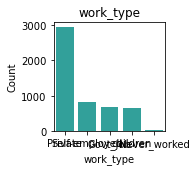

                   work_type  Count  Percent
Private              Private   2925    57.24
Self-employed  Self-employed    819    16.03
children            Govt_job    687    13.44
Govt_job            children    657    12.86
Never_worked    Never_worked     22     0.43
_________________________________________________________________


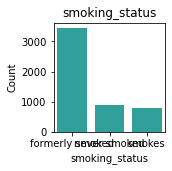

                  smoking_status  Count  Percent
never smoked     formerly smoked   3436    67.24
formerly smoked     never smoked    885    17.32
smokes                    smokes    789    15.44
_________________________________________________________________


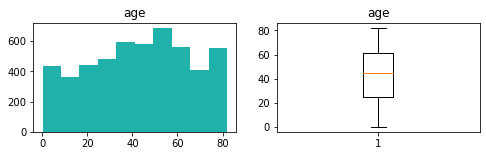

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64


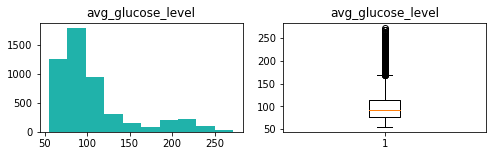

count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64


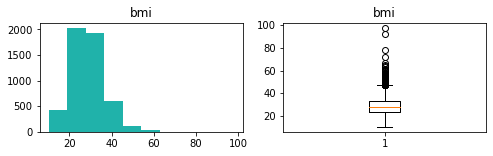

count    5110.000000
mean       28.941370
std         7.767288
min        10.300000
25%        23.700000
50%        28.200000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64


In [19]:
ex.explore_univariate(df, cat_cols, quant_cols)

## Univariate Takeaways

- Age is pretty even across the board
- most work is in private sector
- Avg. glucose and bmi have a right skew, I assume they are related

In [20]:
# Split data
train, validate, test = w.train_validate_test_split(df, target, 42)

In [21]:
# Scale data
train, validate, test = w.train_validate_test_scale(train, validate, test, quant_cols)

hypertension 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=312889.5, pvalue=6.553790077499022e-12)
        chi2       p-value  degrees of freedom
0  45.104902  1.867573e-11                   1

expected:
              0           1
0  2473.458581  121.541419
1   253.541419   12.458581


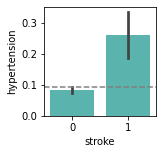


_____________________

heart_disease 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=177857.0, pvalue=1.3889165361181e-09)
        chi2       p-value  degrees of freedom
0  34.311032  4.697115e-09                   1

expected:
              0           1
0  2586.885005  127.114995
1   140.114995    6.885005


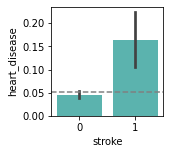


_____________________

ever_married 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=882631.5, pvalue=5.571480011429397e-08)
        chi2       p-value  degrees of freedom
0  28.515153  9.296802e-08                   1

expected:
              0          1
0   939.818944  46.181056
1  1787.181056  87.818944


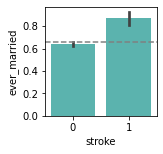


_____________________

rural_residence 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=1025714.5, pvalue=0.7516070397885689)
       chi2   p-value  degrees of freedom
0  0.052054  0.819527                   1

expected:
              0          1
0  1367.789235  67.210765
1  1359.210765  66.789235


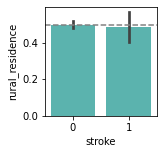


_____________________

urban_residence 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=1020595.5, pvalue=0.7516070397885689)
       chi2   p-value  degrees of freedom
0  0.052054  0.819527                   1

expected:
              0          1
0  1359.210765  66.789235
1  1367.789235  67.210765


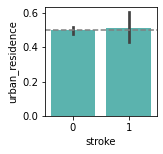


_____________________

current_smoker 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=535904.0, pvalue=0.7775599937041375)
      chi2   p-value  degrees of freedom
0  0.02578  0.872439                   1

expected:
              0           1
0  2302.842363  113.157637
1   424.157637   20.842363


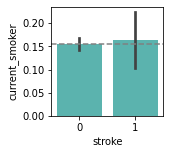


_____________________

is_female 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=995244.5, pvalue=0.44971837116201674)
       chi2   p-value  degrees of freedom
0  0.443677  0.505353                   1

expected:
              0          1
0  1115.200979  54.799021
1  1611.799021  79.200979


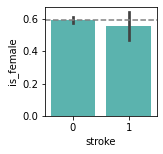


_____________________

is_male 
_____________________


Mann Whitney Test Comparing Means:  MannwhitneyuResult(statistic=983225.5, pvalue=0.44971837116201674)
       chi2   p-value  degrees of freedom
0  0.443677  0.505353                   1

expected:
              0          1
0  1611.799021  79.200979
1  1115.200979  54.799021


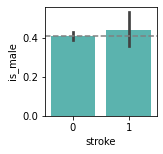


_____________________

age 
____________________



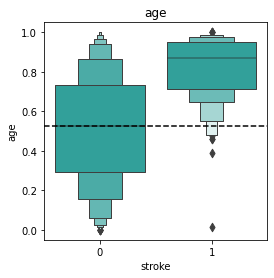

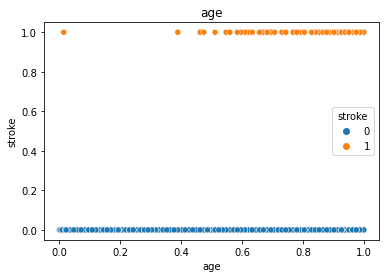

stroke            0           1
count   2727.000000  134.000000
mean       0.511933    0.825772
std        0.274539    0.163637
min        0.000000    0.014174
25%        0.291300    0.712854
50%        0.523460    0.871701
75%        0.731183    0.951124
max        1.000000    1.000000 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.24211461018984456, pvalue=1.9263281778143073e-39)

____________________

avg_glucose_level 
____________________



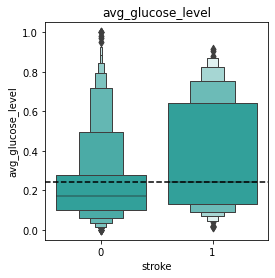

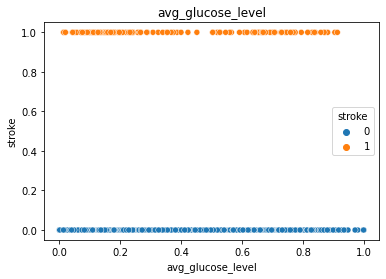

stroke            0           1
count   2727.000000  134.000000
mean       0.237216    0.362258
std        0.210230    0.273339
min        0.000000    0.013168
25%        0.102239    0.129127
50%        0.172733    0.240054
75%        0.275536    0.640366
max        1.000000    0.913234 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.09354143589763018, pvalue=5.38168140031617e-07)

____________________

bmi 
____________________



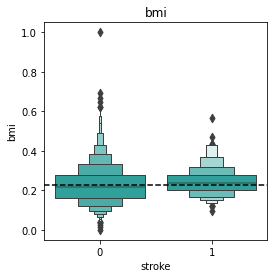

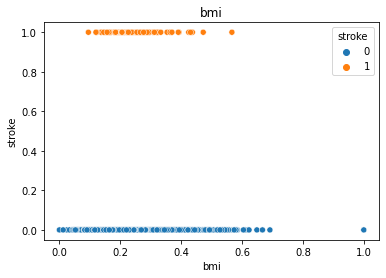

stroke            0           1
count   2727.000000  134.000000
mean       0.227162    0.245389
std        0.096291    0.075386
min        0.000000    0.095165
25%        0.161567    0.200122
50%        0.216952    0.236689
75%        0.277846    0.279682
max        1.000000    0.566707 


Spearman's Correlation Test:
 SpearmanrResult(correlation=0.055086668287861545, pvalue=0.0032041317696408335)

____________________



In [22]:
ex.explore_bivariate(train, target, target, bin_cols, quant_cols)

## Bivariate takeaways

- Good features:
    - hypertension
    - heart disease
    - ever married
    - age
    - glucose
- Bad features:
    - residency
    - gender
    - current smoker
- Need more info:
    - bmi
    - ever_smoked...
   

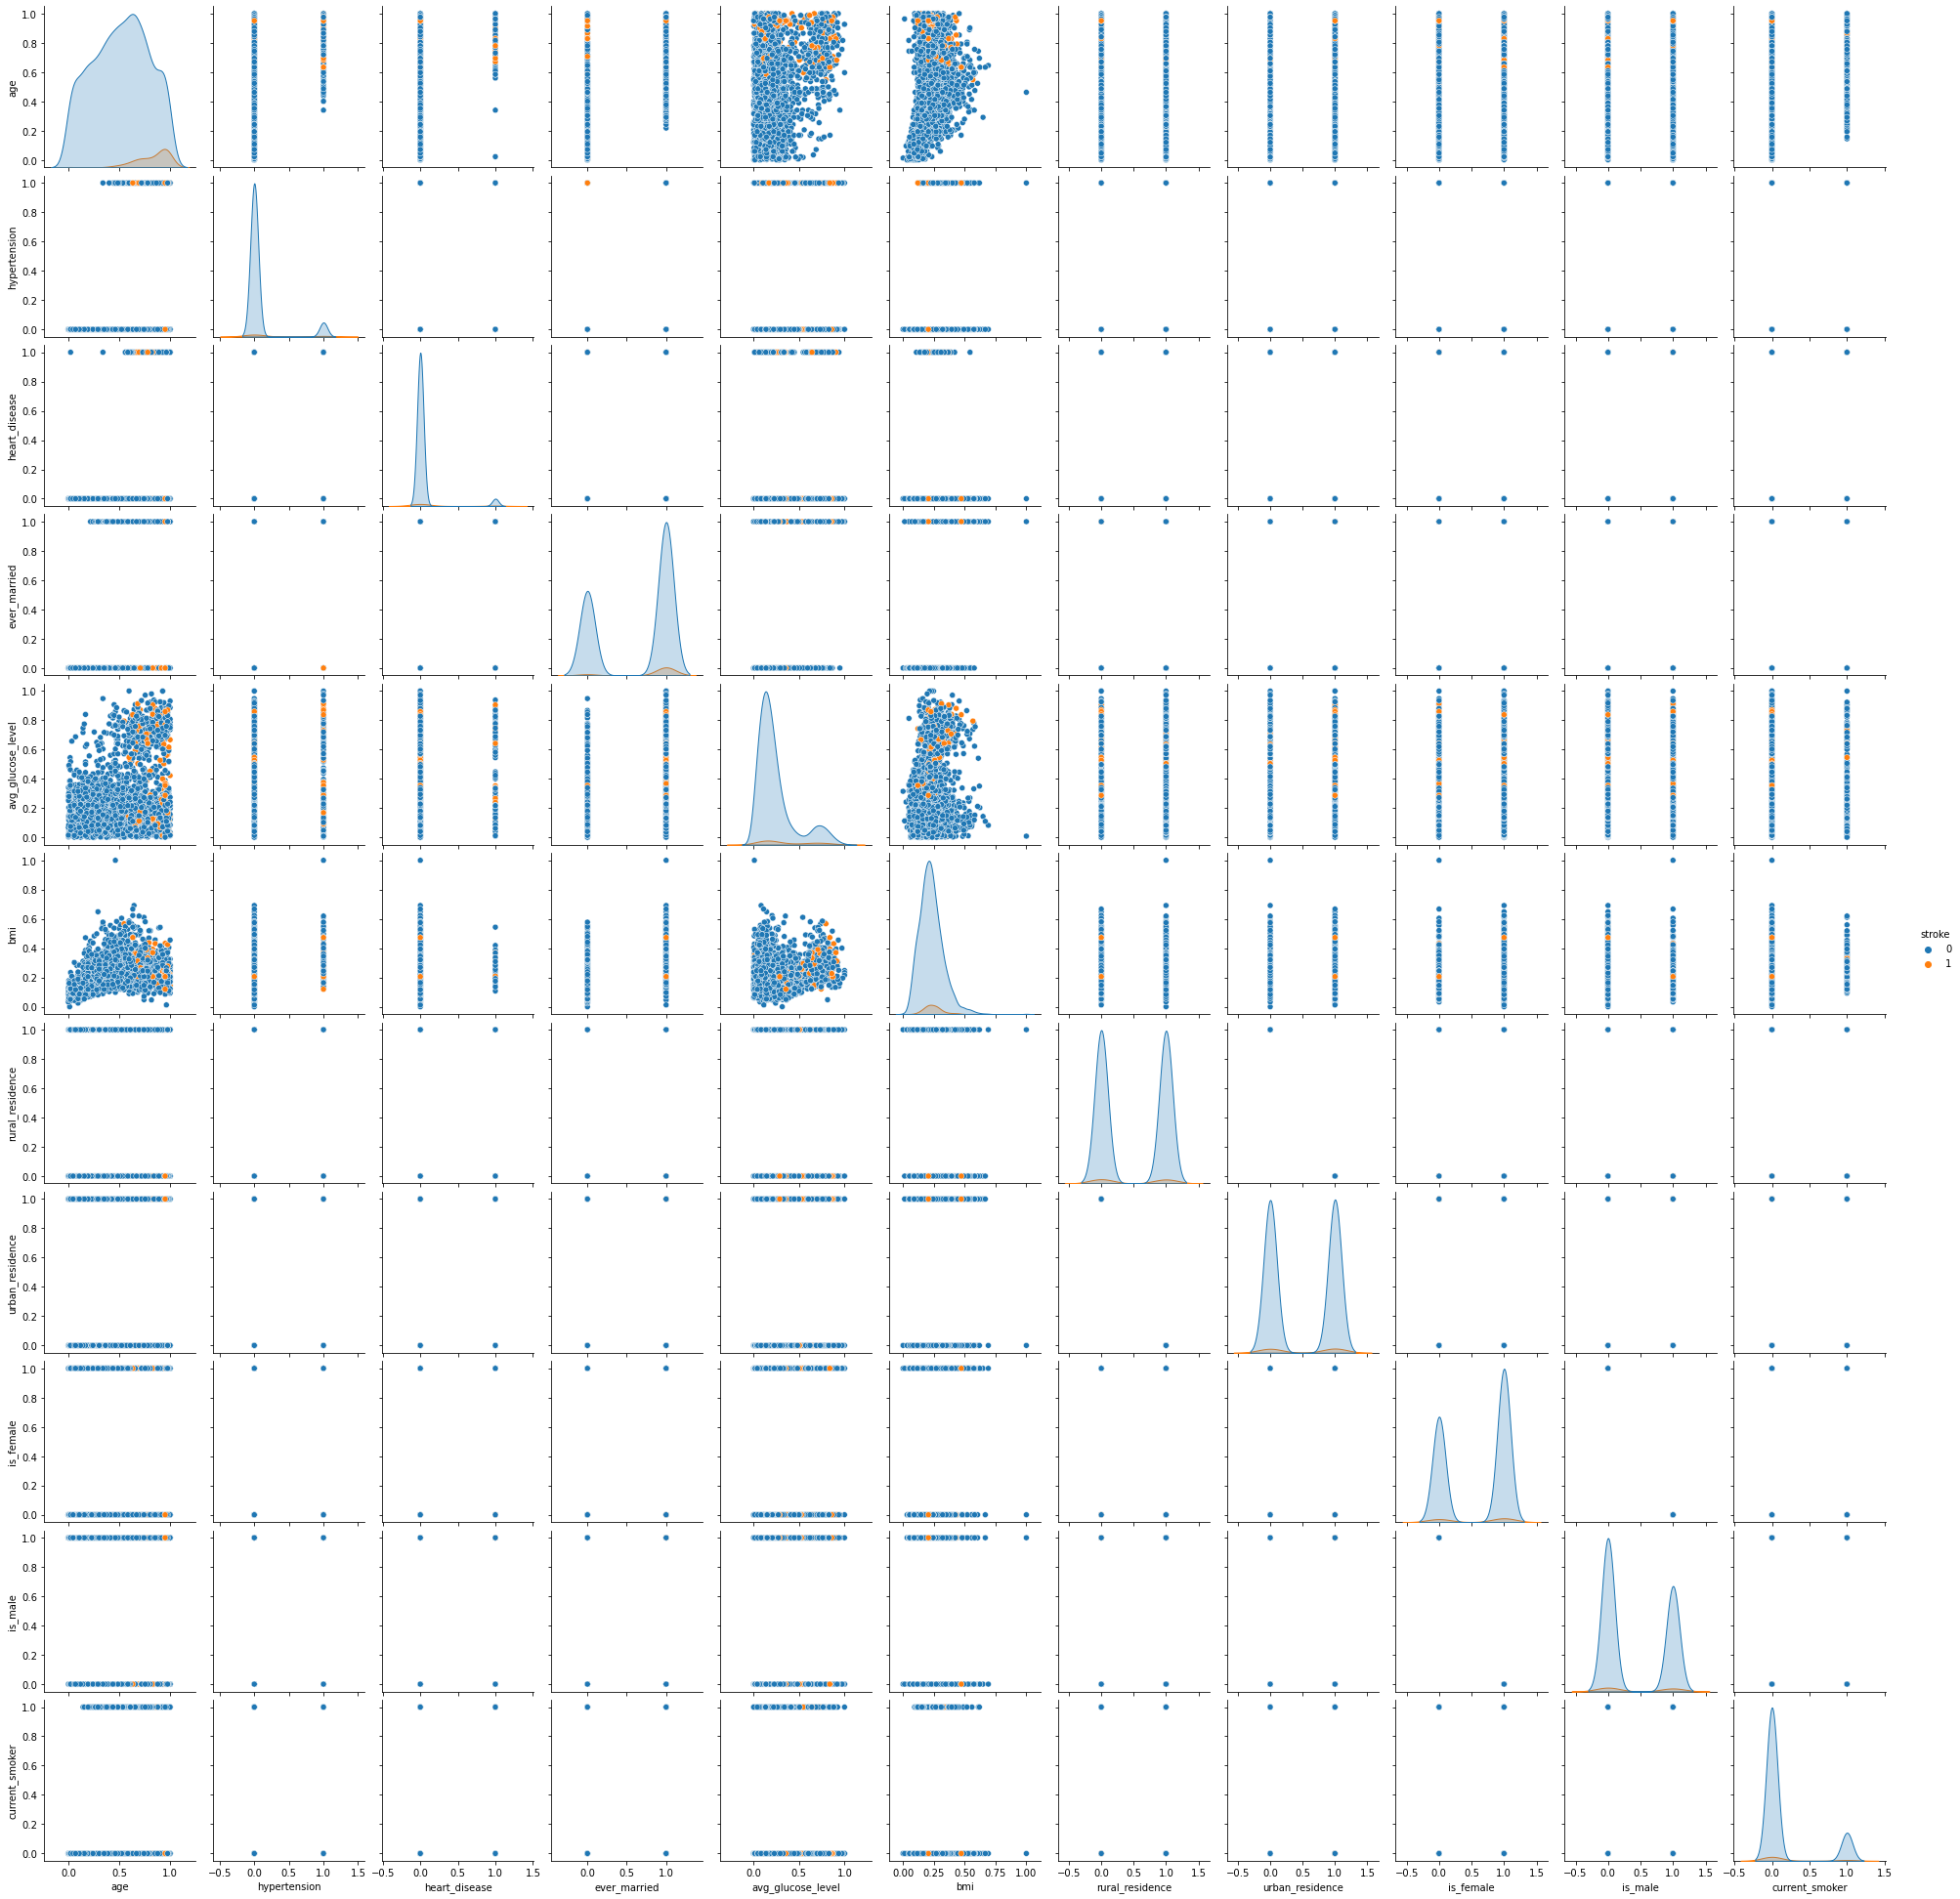

In [34]:
sns.pairplot(train, hue = 'stroke')

<AxesSubplot:xlabel='stroke', ylabel='bmi'>

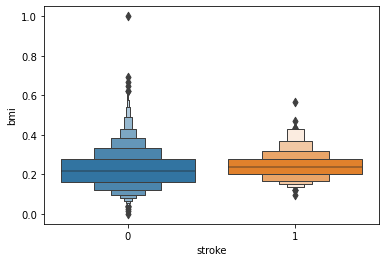

In [39]:
sns.boxenplot(data=train, y='bmi', x='stroke')

## Statistical Analysis

### χ<sup>2</sup> Test

The χ<sup>2</sup> test allows me to test for independence of 2 categorical variables.

### Confidence 

- Confidence level will be 99%
- Alpha will be 0.01 
- p-value must be below 0.01 to be statistically sigificant

### Hypothesis
- The null hypothesis (H<sub>0</sub>) is: hypertension is independent from stroke
- The alternate hypothesis (H<sub>1</sub>) is: hypertension and stroke are dependent

In [24]:
ex.chi2(train, 'hypertension', 'stroke', 0.01)

Observed

[[2496   99]
 [ 231   35]]
---
Expected

[[2473.45858092  121.54141908]
 [ 253.54141908   12.45858092]]
---

chi^2 = 45.1049
p     = 0.0000

Becasue 0.0 is less and 0.01, we reject the null hypothesis


### Hypothesis
- H<sub>0</sub> is: heart diease is independent from stroke
- H<sub>1</sub> is: heart disease and stroke are dependent

In [25]:
ex.chi2(train, 'heart_disease', 'stroke', 0.01)

Observed

[[2602  112]
 [ 125   22]]
---
Expected

[[2586.88500524  127.11499476]
 [ 140.11499476    6.88500524]]
---

chi^2 = 34.3110
p     = 0.0000

Becasue 0.0 is less and 0.01, we reject the null hypothesis


### Hypothesis
- H<sub>0</sub> is: ever married is independent from stroke
- H<sub>1</sub> is: ever married and stroke are dependent

In [26]:
ex.chi2(train, 'ever_married', 'stroke', 0.01)

Observed

[[ 969   17]
 [1758  117]]
---
Expected

[[ 939.81894443   46.18105557]
 [1787.18105557   87.81894443]]
---

chi^2 = 28.5152
p     = 0.0000

Becasue 0.0 is less and 0.01, we reject the null hypothesis


### T-Test

- The T-test allows me to compare the means of 2 subgroups

### Confidence 

- Confidence level will be 99%
- Alpha will be 0.01 
- p-value must be below 0.01 to be statistically sigificant

### Hypothesis: Age of those who have had a stroke vs. the age of the those who have not had a stroke

#### Two Sample, One Tail T-test

- H<sub>0</sub> is: The age of those who have not had a stroke is equal to or higher than the age of those who have had a stroke.
- H<sub>1</sub> is: The age of those who have not had a stroke is significantly less than the age of those who have had a stroke.

In [27]:
age_stroke = train[train.stroke == 1].age
age_no_stroke = train[train.stroke == 0].age

<AxesSubplot:xlabel='stroke', ylabel='age'>

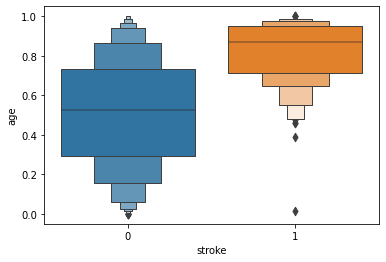

In [40]:
sns.boxenplot(data=train, y='age', x='stroke')

In [29]:
ex.t_test(age_no_stroke, age_stroke, 0.01, sample=2, tail=1, tail_dir='lower')

t-stat = -13.1175
p     = 0.0

Becasue 0.0 is less than 0.01 and -13.1175 is less than 0, we reject the null hypothesis


### Hypothesis: Average glucose level of those who have had a stroke and the average glucose level of those who have not had a stroke.

#### Two Sample, Two Tail T-test

- H<sub>0</sub> is: there is no difference in the glucose levels of those who had a stroke and those who did not
- H<sub>1</sub> is: there is a significant difference in the gluclose levels of those who had a stroke and those who did not

In [30]:
gluc_stroke = train[train.stroke == 1].avg_glucose_level
gluc_no_stroke = train[train.stroke == 0].avg_glucose_level

<AxesSubplot:xlabel='stroke', ylabel='avg_glucose_level'>

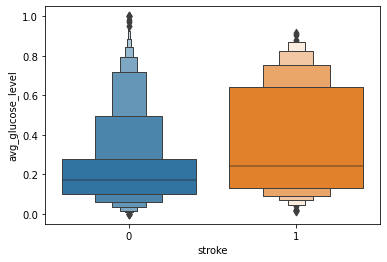

In [41]:
sns.boxenplot(data=train, y='avg_glucose_level', x='stroke')

In [31]:
ex.t_test(gluc_no_stroke, gluc_stroke, 0.01, sample=2)

t-stat = -6.6166
p     = 0.0

Becasue 0.0 is less than 0.01, we reject the null hypothesis


## Statistical Summary

### χ<sup>2</sup> Results
- heart_disease, hypertension, and ever_married all rejected the null hypothesis
- It is now assumed that there is a dependency of each variable and stroke.

### T-test Results
- a two sample one tail t-test was performed on age of those who had a stroke and those who did not have a stroke.
- the null hypothesis was rejected.
- the t-test proved that the age of those who have not had a stroke was significantly less than the age of those who have had a stroke.

- a two sample two tail t-test was performed on average glucose levels of those who had a stroke and those who did not have a stroke.
- the null hypothesis was rejected.

## Modeling